## Llibraries

In [1]:
import os, sys, math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


# CXR-based model

##Load model

In [2]:
!wget 'https://storage.googleapis.com/new_cxr_30/models/cxr_models/k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims%5B128%2C%2064%5D_output_bias%5B-2.07156032%5D_pretrained_feature_layer-2_class_weight%7C0%7C%2010%2C%201%7C%2010%7C_loss_functionbinary_crossentropy.h5'

--2021-05-18 18:15:24--  https://storage.googleapis.com/new_cxr_30/models/cxr_models/k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims%5B128%2C%2064%5D_output_bias%5B-2.07156032%5D_pretrained_feature_layer-2_class_weight%7C0%7C%2010%2C%201%7C%2010%7C_loss_functionbinary_crossentropy.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.217.12.240, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35225912 (34M) [application/octet-stream]
Saving to: ‘k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims[128, 64]_output_bias[-2.07156032]_pretrained_feature_layer-2_class_weight|0| 10, 1| 10|_loss_functionbinary_crossentropy.h5’

k-foldall_augment_b 100%[===================>]  33.59M  98.0MB/s    in 0.3s    

2021-05-18 18:15:25 (98.0 MB/s) - ‘k-foldall_augment_bboxB_dro

In [3]:
model = tf.keras.models.load_model('k-foldall_augment_bboxB_dropout0.5_layers_not_trainable400_lr_init0.002_cxr_hidden_dims[128, 64]_output_bias[-2.07156032]_pretrained_feature_layer-2_class_weight|0| 10, 1| 10|_loss_functionbinary_crossentropy.h5', compile=False)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision()]
)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 326, 326, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [5]:
# predictions = tf.keras.layers.Dense(1, activation='sigmoid', name="dense_a")(base_model.layers[-2].output)

# new_model = tf.keras.Model(inputs=model.layers[-1].input, outputs=model.layers[-1].output)

DL_input = tf.keras.Input(model.layers[-1].input_shape[1:])
new_model = DL_input
for layer in model.layers[-1:]:
    new_model = layer(new_model)
new_model = tf.keras.Model(inputs=DL_input, outputs=new_model)

new_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Precision()]
)

In [6]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
pred_cxr (Dense)             (None, 1)                 65        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


##Load image features

In [9]:
import pandas as pd 

data = pd.read_csv("snuh_image_feature_data_v2.csv") 


In [10]:
feature = data.iloc[:, range(48,112)].to_numpy()

In [12]:
answer = data['expired_30_days'].to_numpy()

In [13]:
feature.shape

(315, 64)

## Prediction

In [14]:
out = new_model.predict(feature)

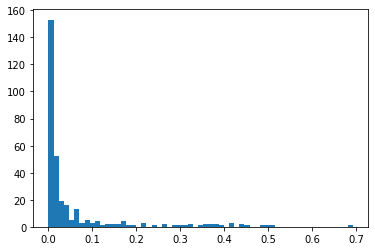

In [15]:
_ = plt.hist(out, bins='auto')

In [16]:
import sklearn.metrics
roc_auc = sklearn.metrics.roc_auc_score(answer, out)
# roc_auc = sklearn.metrics.roc_auc_score(label, out)

In [17]:
roc_auc

0.9032258064516129

In [18]:
out = out.squeeze()

## Reports and plots

In [19]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(answer, out)
optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
optimal_threshold = thresholds[optimal_idx]

## use optimal cut-point 
predicted_class = np.zeros(len(out), dtype=int)
predicted_class[out < optimal_threshold] = 0
predicted_class[out >= optimal_threshold] = 1

## use 0.5 as cut-point 
# predicted_class[predictions < 0.5] = 0
# predicted_class[predictions >= 0.5] = 1
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()

# use softmax
# predicted_class = np.around(predictions).astype(int)
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()


tn, fp, fn, tp = sklearn.metrics.confusion_matrix(answer, predicted_class).ravel()
roc_auc = sklearn.metrics.roc_auc_score(answer, out)
sensitivity = tp / (tp + fn) # recall
specificity = tn / (tn + fp)
PPV = tp / (tp + fp) #precision
NPV = tn / (tn + fn) #NPV
f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
acc = (tp + tn) / (tn + fp + fn + tp)

print(f'AUROC: {roc_auc:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'PPV: {PPV:.2f}')
print(f'NPV: {NPV:.2f}')    
print(f'F1-score: {f1:.2f}')
print(f'Accuracy: {acc:.2f}')
print(f'tn, fp, fn, tp: {tn, fp, fn, tp}')

AUROC: 0.90
Sensitivity: 1.00
Specificity: 0.83
PPV: 0.08
NPV: 1.00
F1-score: 0.16
Accuracy: 0.83
tn, fp, fn, tp: (256, 54, 0, 5)


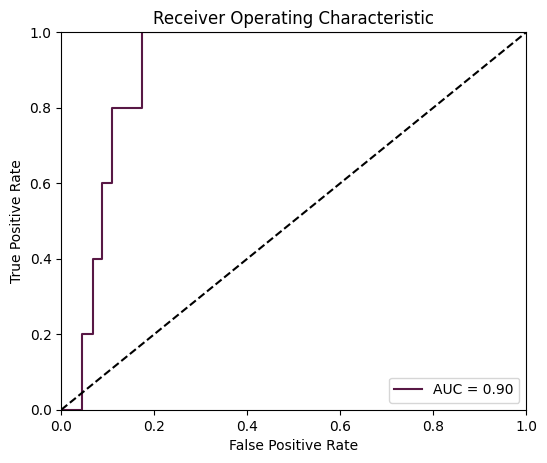

In [20]:
plt.figure(figsize=(6,5),dpi=100)
plt.title('Receiver Operating Characteristic')

color_list = ['#581845','#900C3F','#C70039','#FF5733']
col = 0

from sklearn import metrics

# for clf_name,clf in clf_list:
#     clf = clf.best_estimator_
    # y_prob = clf.predict_proba(x_test)
# prob = y_prob[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(answer, out)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color_list[col], label = f'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
col += 1
plt.savefig("HOBOKEN_CXR.svg")

plt.show();

In [21]:
# np.savetxt("hoboken_prediction_prob.csv", out, delimiter=",")
np.savetxt("snuh_prediction_prob.csv", out, delimiter=",")

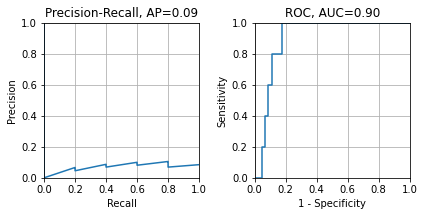

In [22]:
fig, axes = plt.subplots(1, 2)

# Plot the precision-recall curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(answer, out)
average_precision = sklearn.metrics.average_precision_score(answer, out)

pr_axis = axes[0]
pr_axis.plot(recall, precision)
pr_axis.set_aspect('equal')
pr_axis.set_xlim(0, 1)
pr_axis.set_ylim(0, 1)
pr_axis.set_xlabel('Recall')
pr_axis.set_ylabel('Precision')
pr_axis.set_title('Precision-Recall, AP={:.2f}'.format(average_precision))
pr_axis.grid(True)

# Plot the ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(answer, out)
roc_auc = sklearn.metrics.roc_auc_score(answer, out)

roc_axis = axes[1]
roc_axis.plot(fpr, tpr)
roc_axis.set_aspect('equal')
roc_axis.set_xlim(0, 1)
roc_axis.set_ylim(0, 1)
roc_axis.set_xlabel('1 - Specificity')
roc_axis.set_ylabel('Sensitivity')
roc_axis.set_title('ROC, AUC={:.2f}'.format(roc_auc))
roc_axis.grid(True)

plt.tight_layout()

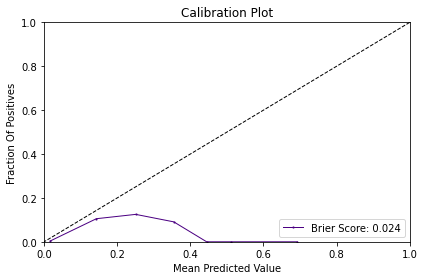

In [23]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

title_calibration='Calibration Plot'
plt.title(title_calibration)
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel("Fraction Of Positives")
plt.xlabel("Mean Predicted Value")
plt.plot([1, 0], [1, 0],"k--",linewidth=1)

fraction_of_positives, mean_predicted_value = calibration_curve(answer, out,n_bins=10)
brier_score = brier_score_loss(answer, out)
plt.plot(mean_predicted_value, fraction_of_positives, "rs-",markersize=1,label=f'Brier Score: {np.round(brier_score,3)}',color='indigo',linewidth=1)
plt.legend(loc="lower right")
plt.tight_layout()

# EHR-based and EHR-CXR fusion models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

## Load and check the variables 

In [ ]:
df_hm = pd.read_csv('/content/gdrive/MyDrive/covid19/predictions_cxr_model_4fold_models_predictions_v2.csv')


In [ ]:
df_hm = df_hm.drop(columns=['Unnamed: 0', 'SOPInstanceUID','path','APview','bbox_coordinates','expired_30_days', 'fold'])
df_hm = df_hm.set_index('patient_id')
df_hm = df_hm.sort_index()


In [ ]:
a = list(df_hm.columns)

In [ ]:
EHR_data = data.iloc[:, range(1,48)]

In [ ]:
data.columns

Index(['PATIENT ID', 'age', 'expired_30_days', 'vitals_temp_ed_first',
       'vitals_sbp_ed_first', 'vitals_dbp_ed_first', 'vitals_hr_ed_first',
       'pmhx_diabetes', 'pmhx_hld', 'pmhx_htn',
       ...
       'feat_0056', 'feat_0057', 'feat_0058', 'feat_0059', 'feat_0060',
       'feat_0061', 'feat_0062', 'feat_0063', 'feat_0064', 'path'],
      dtype='object', length=113)

In [ ]:
y_test = EHR_data['expired_30_days'].to_numpy()
EHR_data = EHR_data.drop(columns='expired_30_days')

In [ ]:
b = list(EHR_data.columns)

In [ ]:
list(set(a) - set(b))

[]

In [ ]:
EHR_data = EHR_data[a]

Drop CXR-model result for EHR-based model

In [ ]:
EHR_data = EHR_data.drop(columns='predicted_probability')

## Load model

In [ ]:
from sklearn.externals import joblib
from sklearn.metrics import classification_report, precision_recall_curve, plot_precision_recall_curve, average_precision_score, brier_score_loss, roc_curve
import glob

model_path = './gdrive/My Drive/covid19/models/'

# fpath = glob.glob(model_path+'*_str_only_bestf11.pkl') 
fpath = glob.glob(model_path+'*_bestf11.pkl') 

clf = joblib.load(os.path.join(fpath[0])) 

## Prediction

In [ ]:
ypred = clf.predict(EHR_data)
y_prob = clf.predict_proba(EHR_data)
print(classification_report(y_true=y_test,y_pred=ypred))
print(clf.score)

              precision    recall  f1-score   support

           0       0.62      0.93      0.74       114
           1       0.72      0.24      0.36        87

    accuracy                           0.63       201
   macro avg       0.67      0.59      0.55       201
weighted avg       0.66      0.63      0.58       201

<bound method ClassifierMixin.score of SGDClassifier(alpha=0.000677664206148106, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.020257449404317077, learning_rate='optimal',
              loss='log', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l1', power_t=0.5, random_state=2020, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)>


## Reports and plots

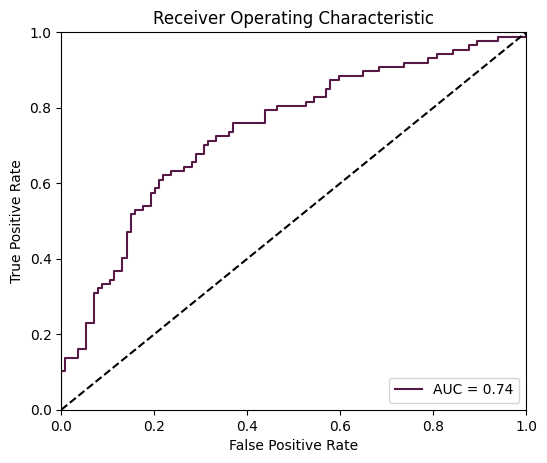

In [ ]:
plt.figure(figsize=(6,5),dpi=100)
plt.title('Receiver Operating Characteristic')

color_list = ['#581845','#900C3F','#C70039','#FF5733']
col = 0

from sklearn import metrics

# for clf_name,clf in clf_list:
#     clf = clf.best_estimator_
    # y_prob = clf.predict_proba(x_test)
prob = y_prob[:,1]
fpr, tpr, threshold = roc_curve(y_test, prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color_list[col], label = f'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
col += 1
plt.savefig("output.svg")

plt.show();

In [ ]:
import sklearn.metrics
from sklearn.metrics import roc_auc_score, recall_score, make_scorer


fpr, tpr, thresholds = roc_curve(y_test, prob)
optimal_idx = np.argmin((1-tpr)**2+ (fpr)**2 )
optimal_threshold = thresholds[optimal_idx]

## use optimal cut-point 
predicted_class = np.zeros(len(prob), dtype=int)
predicted_class[prob < optimal_threshold] = 0
predicted_class[prob >= optimal_threshold] = 1

## use 0.5 as cut-point 
# predicted_class[predictions < 0.5] = 0
# predicted_class[predictions >= 0.5] = 1
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()

# use softmax
# predicted_class = np.around(predictions).astype(int)
# predicted_class_name = np.array(CLASSES)[predicted_class].tolist()


tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, predicted_class).ravel()
roc_auc = roc_auc_score(y_test, prob)
sensitivity = tp / (tp + fn) # recall
specificity = tn / (tn + fp)
PPV = tp / (tp + fp) #precision
NPV = tn / (tn + fn) #NPV
f1 = 2 * ((tp / (tp + fp)) * (tp / (tp + fn)) )/ ((tp / (tp + fp)) + (tp / (tp + fn)))
acc = (tp + tn) / (tn + fp + fn + tp)

print(f'AUROC: {roc_auc:.2f}')
print(f'Sensitivity: {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'PPV: {PPV:.2f}')
print(f'NPV: {NPV:.2f}')    
print(f'F1-score: {f1:.2f}')
print(f'Accuracy: {acc:.2f}')
print(f'tn, fp, fn, tp: {tn, fp, fn, tp}')

AUROC: 0.74
Sensitivity: 0.71
Specificity: 0.68
PPV: 0.63
NPV: 0.76
F1-score: 0.67
Accuracy: 0.70
tn, fp, fn, tp: (78, 36, 25, 62)
